In [1]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
run load_im_labels2.py

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [9]:
NUM_CLASSES = 62
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = np.eye(NUM_CLASSES)[y_train[:,0]]
y_test2 = np.eye(NUM_CLASSES)[y_test[:,0]]

In [6]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU

def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()

    model.add(Conv2D(16, (3, 3), input_shape=(100,100,3), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256))
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES))
    model.add(Activation("softmax"))
    
    return model

In [7]:
# describe model
K.clear_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 100, 100, 16)      448       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 100, 100, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 32)        9248      
__________

In [10]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

# fit model
model.fit(
    x_train, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), LrHistory()],
    validation_data=(x_test, y_test2),
    shuffle=True,
)

Train on 4575 samples, validate on 2520 samples
Epoch 1/10
Learning rate: 0.005
4575/4575 [==============================] - 407s 89ms/step - loss: 2.2126 - acc: 0.4883 - val_loss: 0.8115 - val_acc: 0.8147
Epoch 2/10
Learning rate: 0.0045
4575/4575 [==============================] - 419s 92ms/step - loss: 0.5741 - acc: 0.8474 - val_loss: 0.3499 - val_acc: 0.9103
Epoch 3/10
Learning rate: 0.00405
4575/4575 [==============================] - 413s 90ms/step - loss: 0.2078 - acc: 0.9447 - val_loss: 0.2857 - val_acc: 0.9198
Epoch 4/10
Learning rate: 0.003645
4575/4575 [==============================] - 409s 89ms/step - loss: 0.1328 - acc: 0.9648 - val_loss: 0.2773 - val_acc: 0.9246
Epoch 5/10
Learning rate: 0.0032805
4575/4575 [==============================] - 413s 90ms/step - loss: 0.0820 - acc: 0.9773 - val_loss: 0.2935 - val_acc: 0.9294
Epoch 6/10
Learning rate: 0.00295245
4575/4575 [==============================] - 427s 93ms/step - loss: 0.0585 - acc: 0.9860 - val_loss: 0.2767 - val_a

In [11]:
# make test predictions
y_pred_test = model.predict_proba(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

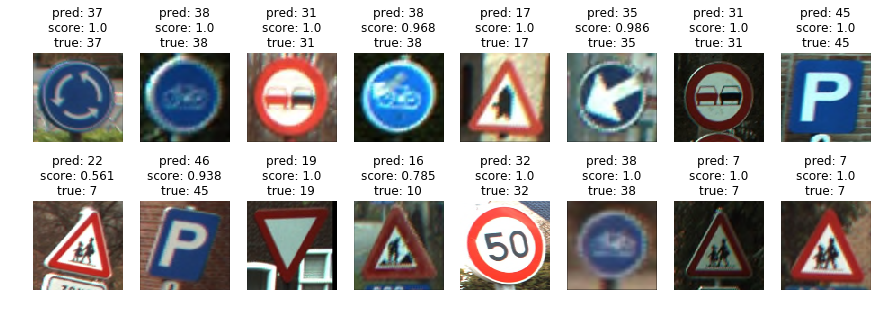

In [12]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = y_pred_test_classes[random_index]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = y_test[random_index, 0]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score
print("Test accuracy:", (accuracy_score(y_test, y_pred_test_classes))*100, "%")

Test accuracy: 94.12698412698413 %
